In [32]:
!pip install statsmodels

In [ ]:
pip install -U imbalanced-learn

In [1]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import optuna


import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import plot_tree
from sklearn.metrics import precision_recall_curve
from optuna.visualization import plot_optimization_history
from sklearn.metrics import classification_report, precision_score, recall_score,accuracy_score, f1_score,ConfusionMatrixDisplay

In [34]:
df=pd.read_csv("df.csv")
df.head(2)

,customer_id,month,age,occupation,annual_income,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,type_of_loan,...,credit_mix,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,monthly_balance,credit_score,payment_behaviour
0,CUS_0xd40,January,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,26.822620,265.0,No,49.574949,80.415295,312.494089,Good,High_spent_Medium_value_payments
1,CUS_0xd40,March,23.0,Scientist,19114.12,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,28.609352,267.0,No,49.574949,81.699521,331.209863,Good,High_spent_Medium_value_payments


In [35]:
df=df.drop(["customer_id","month","age","occupation","type_of_loan","amount_invested_monthly","total_emi_per_month"],axis=1)
df.head()

,annual_income,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,monthly_balance,credit_score,payment_behaviour
0,19114.12,3.0,4.0,3.0,4.0,3,7.0,11.27,4.0,Good,809.98,26.822620,265.0,No,312.494089,Good,High_spent_Medium_value_payments
1,19114.12,3.0,4.0,3.0,4.0,3,7.0,10.27,4.0,Good,809.98,28.609352,267.0,No,331.209863,Good,High_spent_Medium_value_payments
2,19114.12,3.0,4.0,3.0,4.0,5,4.0,6.27,4.0,Good,809.98,31.377862,268.0,No,223.451310,Good,High_spent_Medium_value_payments
3,19114.12,3.0,4.0,3.0,4.0,6,6.0,11.27,4.0,Good,809.98,24.797347,269.0,No,341.489231,Good,High_spent_Medium_value_payments
4,19114.12,3.0,4.0,3.0,4.0,8,4.0,9.27,4.0,Good,809.98,27.262259,270.0,No,340.479212,Good,High_spent_Medium_value_payments


In [36]:
df1=df.drop(columns=["credit_score"])

In [37]:
le=LabelEncoder()
ohe=OneHotEncoder()
df["credit_mix"]=le.fit_transform(df["credit_mix"])
s=pd.DataFrame(ohe.fit_transform(df[["payment_behaviour","payment_of_min_amount"]]).toarray())

In [38]:
df=df.drop(columns=["payment_behaviour","payment_of_min_amount"])
df=df.join(s)

In [39]:
y=df["credit_score"]
X=df.drop(columns=["credit_score"])

In [40]:
X.shape

(59028, 23)

In [41]:
# v=pd.DataFrame(X)
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# vif = pd.DataFrame()
# vif["Variable"] = v.columns
# vif["VIF"] = [variance_inflation_factor(v.values, i) for i in range(v.shape[1])]
# d=pd.DataFrame({"column":v.columns,"VIF":vif["VIF"]})

In [42]:
y=le.fit_transform(df["credit_score"])

In [43]:
se=StandardScaler()
X=se.fit_transform(X)

In [44]:
train_X,test_X,train_y,test_y=train_test_split(X,y,test_size=0.2,stratify=y)

In [45]:
print(train_X.shape,test_X.shape,train_y.shape,test_y.shape)

(47222, 23) (11806, 23) (47222,) (11806,)


In [46]:
# ohe=OneHotEncoder()
# le1=le.fit_transform(df["credit_mix"])
# dummy=pd.get_dummies(df[["payment_behaviour","payment_of_min_amount"]])
# X=X.drop(["credit_mix","payment_behaviour","payment_of_min_amount"],axis=1)

In [47]:
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
# scores = []
# folds=list(kfold.split(X_train,y_train))
# for k,(train,test) in enumerate(folds):
#     pipe_lr.fit(train_X[train], train_y[train])
#     score = (X_train[test], y_train[test])
#     scores.append(score)
#     print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]),score))

In [48]:
def train_and_evaluate_model(model):
        model.fit(train_X,train_y)
        y_pred=model.predict(train_X)
        print(classification_report(train_y,y_pred))
        acc=accuracy_score(train_y,y_pred)
        precision=precision_score(train_y,y_pred,average="micro")
        recall=recall_score(train_y,y_pred,average="micro")
        f1=f1_score(train_y,y_pred,average="micro")
        ConfusionMatrixDisplay.from_predictions(train_y,y_pred)
        plt.show()


In [49]:
model_names1 = []
accuracy_scores1 = []
precision_scores1 = []
recall_scores1 = []
f1_scores1 = []

In [51]:
def test_and_evaluate_model(model):
    model.fit(train_X,train_y)
    y_pred=model.predict(test_X)
    print(classification_report(test_y,y_pred))
    acc=accuracy_score(test_y,y_pred)
    precision=precision_score(test_y,y_pred,average="micro")
    recall=recall_score(test_y,y_pred,average="micro")
    f1=f1_score(test_y,y_pred,average="micro")
    ConfusionMatrixDisplay.from_predictions(test_y,y_pred)
    plt.show()
    model_names1.append(model)
    accuracy_scores1.append(acc)
    precision_scores1.append(precision)
    recall_scores1.append(recall)
    f1_scores1.append(f1)

# Random forest classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6054
           1       1.00      1.00      1.00     15730
           2       1.00      1.00      1.00     25438

    accuracy                           1.00     47222
   macro avg       1.00      1.00      1.00     47222
weighted avg       1.00      1.00      1.00     47222



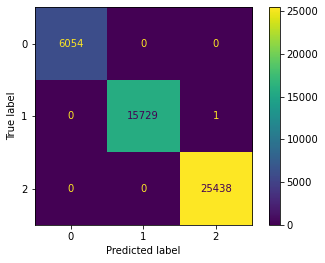

In [52]:
train_and_evaluate_model(RandomForestClassifier())

              precision    recall  f1-score   support

           0       0.77      0.69      0.73      1514
           1       0.80      0.83      0.81      3933
           2       0.83      0.82      0.83      6359

    accuracy                           0.81     11806
   macro avg       0.80      0.78      0.79     11806
weighted avg       0.81      0.81      0.81     11806



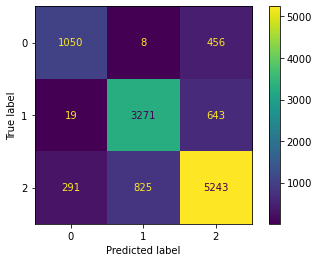

In [53]:
test_and_evaluate_model(RandomForestClassifier())

## Hyperparamter tuning

In [54]:
param_grid = {'criterion': ['gini','entropy'],
              'max_features': ['sqrt','log2'],
              'max_depth': [2,12,38,68,98,128,201]
             }

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6054
           1       1.00      1.00      1.00     15730
           2       1.00      1.00      1.00     25438

    accuracy                           1.00     47222
   macro avg       1.00      1.00      1.00     47222
weighted avg       1.00      1.00      1.00     47222



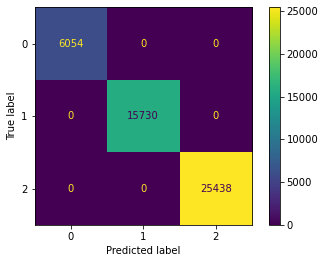

In [55]:
grid_dt = RandomizedSearchCV(RandomForestClassifier(),param_grid,n_jobs=1,cv=5)

train_and_evaluate_model(grid_dt)

              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1514
           1       0.79      0.84      0.82      3933
           2       0.83      0.82      0.82      6359

    accuracy                           0.81     11806
   macro avg       0.79      0.78      0.79     11806
weighted avg       0.81      0.81      0.81     11806



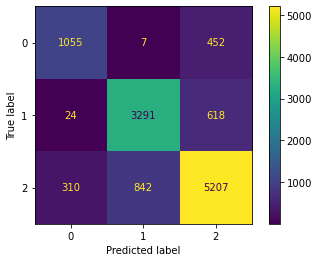

In [56]:
grid_dt = RandomizedSearchCV(RandomForestClassifier(),param_grid,n_jobs=1,cv=5)
test_and_evaluate_model(grid_dt)

# logistic Regression

              precision    recall  f1-score   support

           0       0.58      0.45      0.51      6054
           1       0.68      0.59      0.63     15730
           2       0.68      0.77      0.72     25438

    accuracy                           0.67     47222
   macro avg       0.64      0.60      0.62     47222
weighted avg       0.66      0.67      0.66     47222



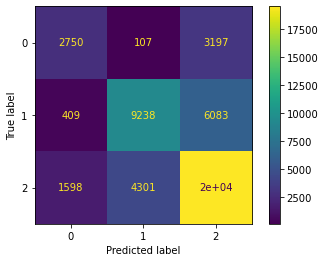

In [57]:
train_and_evaluate_model(LogisticRegression(penalty="l2",random_state=1,multi_class="multinomial"))

              precision    recall  f1-score   support

           0       0.59      0.48      0.53      1514
           1       0.68      0.58      0.63      3933
           2       0.68      0.77      0.72      6359

    accuracy                           0.67     11806
   macro avg       0.65      0.61      0.63     11806
weighted avg       0.67      0.67      0.67     11806



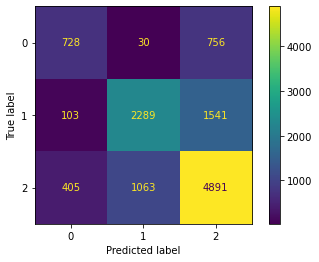

In [58]:
test_and_evaluate_model(LogisticRegression(penalty="l2",random_state=1,multi_class="multinomial"))

# hyper parameter tuning

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=10, l1_ratio=0.2, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=10, l1_ratio=0.2, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=10, l1_ratio=0.2, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=10, l1_ratio=0.2, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=10, l1_ratio=0.2, multi_class=ovr, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END C=1, l1_ratio=0.8, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, l1_ratio=0.8, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, l1_ratio=0.8, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, l1_ratio=0.8, multi_class=ovr, penalty=l2, solver=liblinear; total time=   0.8s
[CV] END C=1, l1_ratio=0.8, multi_class=ovr, penalty=l2, solver=liblinear; tot

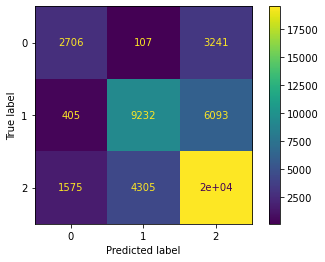

In [59]:
param_grid = {'penalty': ['l1','l2','elasticnet'],
              'C': [0.001,0.01,1,10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'multi_class': ['ovr', 'multinomial'],
              'l1_ratio': [0.2,0.5,0.8]
             }

grid_lr = RandomizedSearchCV(LogisticRegression(),param_grid,verbose=2,cv=5)
train_and_evaluate_model(grid_lr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END C=1, l1_ratio=0.8, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1, l1_ratio=0.8, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1, l1_ratio=0.8, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1, l1_ratio=0.8, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=1, l1_ratio=0.8, multi_class=multinomial, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, l1_ratio=0.8, multi_class=multinomial, penalty=l2, solver=sag; total time=   1.0s
[CV] END C=0.01, l1_ratio=0.8, multi_class=multinomial, penalty=l2, solver=sag; total time=   1.2s
[CV] END C=0.01, l1_ratio=0.8, multi_class=multinomial, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=0.01, l1_ratio=0.8, multi_class=multinomial, penalty=l2, solver=sag; total time=   1.1s
[CV] END C=0.

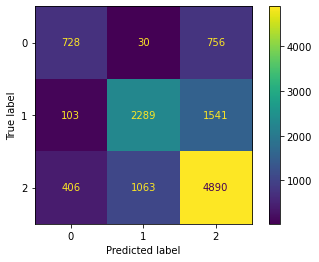

In [60]:
param_grid = {'penalty': ['l1','l2','elasticnet'],
              'C': [0.001,0.01,0.1,1,10],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'multi_class': ['ovr', 'multinomial'],
              'l1_ratio': [0.2,0.5,0.8]
             }

grid_lr = RandomizedSearchCV(LogisticRegression(),param_grid,verbose=2)

test_and_evaluate_model(grid_lr)

# KNN

In [57]:
def elbow(k):
    test_error=[]
    for i in k:
        clf=KNeighborsClassifier(n_neighbors=i)
        clf.fit(train_X,train_y)
        tmp=clf.predict(test_X)
        tmp=f1_score(test_y,tmp,average="micro")
        error=1-tmp
        test_error.append(error)
    return test_error

In [59]:
k=range(6,20)
test=elbow(k)

Text(0.5, 1.0, 'elbow curve for test')

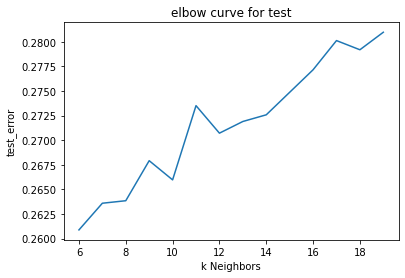

In [61]:
plt.plot(k,test)
plt.xlabel("k Neighbors")
plt.ylabel("test_error")
plt.title("elbow curve for test")

              precision    recall  f1-score   support

           0       0.69      0.76      0.72      6054
           1       0.78      0.86      0.82     15730
           2       0.86      0.79      0.83     25438

    accuracy                           0.81     47222
   macro avg       0.78      0.80      0.79     47222
weighted avg       0.81      0.81      0.81     47222



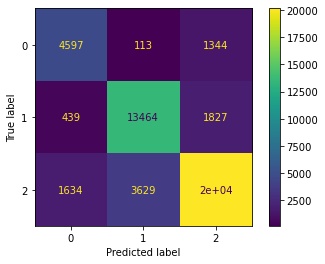

In [62]:
train_and_evaluate_model(KNeighborsClassifier(n_neighbors=6))

              precision    recall  f1-score   support

           0       0.58      0.64      0.61      1514
           1       0.72      0.78      0.75      3933
           2       0.79      0.74      0.76      6359

    accuracy                           0.74     11806
   macro avg       0.70      0.72      0.71     11806
weighted avg       0.74      0.74      0.74     11806



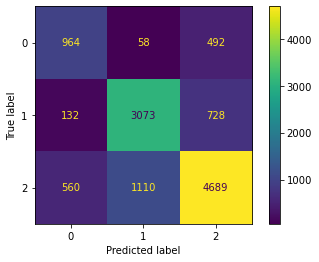

In [65]:
test_and_evaluate_model(KNeighborsClassifier(n_neighbors=6))

In [70]:
y

array([0, 0, 0, ..., 1, 2, 1])

In [71]:
from sklearn.model_selection import validation_curve
param_range =[1,3,6,9]
train_score, test_score = validation_curve(KNeighborsClassifier(), train_X, train_y,
                                           param_name="n_neighbors",
                                           param_range=param_range,
                                           cv=5, scoring="accuracy")

In [72]:
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)
 

In [73]:
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

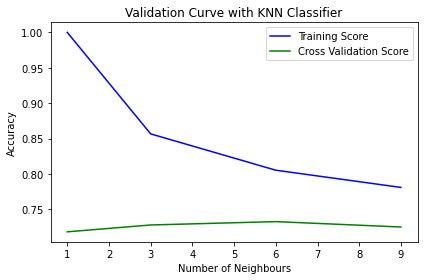

In [74]:
plt.plot(param_range, mean_train_score,
         label="Training Score", color='b')
plt.plot(param_range, mean_test_score,
         label="Cross Validation Score", color='g')
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc='best')
plt.show()

              precision    recall  f1-score   support

           0       0.69      0.69      0.69      6054
           1       0.79      0.79      0.79     15730
           2       0.82      0.82      0.82     25438

    accuracy                           0.79     47222
   macro avg       0.76      0.76      0.76     47222
weighted avg       0.79      0.79      0.79     47222



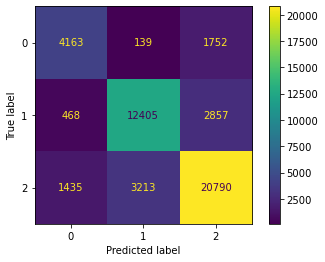

In [75]:
train_and_evaluate_model(KNeighborsClassifier(n_neighbors=9))

              precision    recall  f1-score   support

           0       0.59      0.60      0.60      1514
           1       0.74      0.73      0.74      3933
           2       0.77      0.77      0.77      6359

    accuracy                           0.74     11806
   macro avg       0.70      0.70      0.70     11806
weighted avg       0.74      0.74      0.74     11806



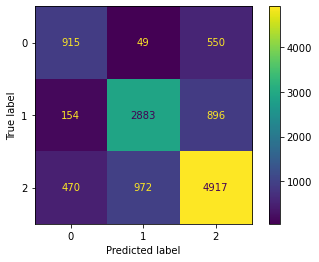

In [61]:
test_and_evaluate_model(KNeighborsClassifier(n_neighbors=9))

In [62]:
model_performmance=pd.DataFrame({"model":model_names1,"accuracy":accuracy_scores1,
                                "precision":precision_scores1,"recall":recall_scores1,
                                "f1_score":f1_scores1}).sort_values("accuracy",ascending=False)
model_performmance

,model,accuracy,precision,recall,f1_score
0,"(DecisionTreeClassifier(max_features='auto', r...",0.810097,0.810097,0.810097,0.810097
1,"RandomizedSearchCV(cv=5, estimator=RandomFores...",0.809165,0.809165,0.809165,0.809165
4,KNeighborsClassifier(n_neighbors=9),0.738184,0.738184,0.738184,0.738184
2,"LogisticRegression(multi_class='multinomial', ...",0.669829,0.669829,0.669829,0.669829
3,RandomizedSearchCV(estimator=LogisticRegressio...,0.669744,0.669744,0.669744,0.669744


In [65]:
X.shape

(59028, 23)

## backpropogation

In [78]:
learning_rate = 0.1
iterations = 5000
N = train_y.size
# number of input features
input_size = 23
# number of hidden layers neurons
hidden_size = 2
# number of neurons at the output layer
output_size = 3
results = pd.DataFrame(columns=["mse", "accuracy"])

In [80]:
np.random.seed(10)
# initializing weight for the hidden layer
W1 = np.random.normal(scale=0.5, size=(input_size, hidden_size))
print("Weight for the hidden layer \n", W1, "\n")
# initializing weight for the output layer
W2 = np.random.normal(scale=0.5, size=(hidden_size , output_size))
print("Weight for the output layer \n", W2)

Weight for the hidden layer 
 [[ 0.66579325  0.35763949]
 [-0.77270015 -0.00419192]
 [ 0.31066799 -0.36004278]
 [ 0.13275579  0.05427426]
 [ 0.00214572 -0.08730011]
 [ 0.21651309  0.60151869]
 [-0.48253284  0.51413704]
 [ 0.11431507  0.22256881]
 [-0.56830111  0.06756844]
 [ 0.7422685  -0.53990244]
 [-0.98886414 -0.87168615]
 [ 0.13303508  1.19248367]
 [ 0.56184563  0.83631111]
 [ 0.04957461  0.69899819]
 [-0.13562399  0.30660209]
 [-0.13365859 -0.27465451]
 [ 0.06635415 -0.23807101]
 [ 0.65423654  0.09750664]
 [ 0.20010499 -0.16881617]
 [ 0.62823613 -0.36598475]
 [ 0.33011578 -0.17543595]
 [-0.46971668 -0.24466861]
 [-0.40229557 -0.10634882]] 

Weight for the output layer 
 [[-0.16957012  0.15608497  0.28257633]
 [-0.07371013 -0.01295267  0.1445471 ]]


In [103]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def mean_squared_error(y_pred, y_true):
    y_true_one_hot = np.eye(output_size)[y_true]
    y_true_reshaped = y_true_one_hot.reshape(y_pred.shape)
    return ((y_pred - y_true_reshaped)**2).sum() / (2*y_pred.size)
def accuracy(y_pred, y_true):
    acc = y_pred.argmax(axis=1) == y_true.argmax(axis=1)
    return acc.mean()

In [104]:
print(W2.shape)
print(A2.shape)
print(train_y.shape)

(2, 3)
(47222, 3)
(47222,)


In [109]:
import warnings

warnings.filterwarnings('ignore')
for itr in range(iterations):
    Z1 = np.dot(train_X, W1)
    A1 = sigmoid(Z1)
    Z2 = np.dot(A1, W2)
    A2 = sigmoid(Z2)
    mse = mean_squared_error(A2,train_y)
    acc = accuracy(np.eye(output_size)[train_y], A2)
    results=results.append({"mse":mse, "accuracy":acc},ignore_index=True )
    # backpropagation
    E1 = A2 - np.eye(output_size)[train_y]
    dW1 = E1 * A2 * (1 - A2)
    E2 = np.dot(dW1, W2.T)
    dW2 = E2 * A1 * (1 - A1)

    # weight updates
    W2_update = np.dot(A1.T, dW1) / N
    W1_update = np.dot(train_X.T, dW2) / N
    W2 = W2 - learning_rate * W2_update
    W1 = W1 - learning_rate * W1_update

<AxesSubplot:title={'center':'Mean Squared Error'}>

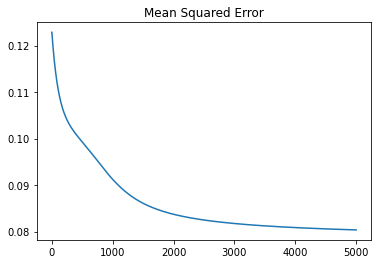

In [110]:
results.mse.plot(title="Mean Squared Error")

<AxesSubplot:title={'center':'Accuracy'}>

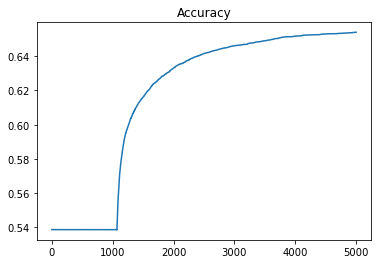

In [111]:
results.accuracy.plot(title="Accuracy")

In [115]:
Z1 = np.dot(test_X, W1)
A1 = sigmoid(Z1)
Z2 = np.dot(A1, W2)
A2 = sigmoid(Z2)
acc = accuracy(np.eye(output_size)[test_y], A2)

print("Accuracy: {}".format(acc))

Accuracy: 0.6504319837370829


In [24]:
model=RandomForestClassifier()

In [28]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
scores = []
folds=list(kfold.split(train_X,train_y))
for k,(train,test) in enumerate(folds):
    model.fit(train_X[train], train_y[train])
    score = model.score(train_X[test], train_y[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(train_y[train]),score))

Fold: 1, Class dist.: [ 5448 14157 22894], Acc: 0.803
Fold: 2, Class dist.: [ 5448 14157 22894], Acc: 0.799
Fold: 3, Class dist.: [ 5448 14157 22895], Acc: 0.812
Fold: 4, Class dist.: [ 5448 14157 22895], Acc: 0.806
Fold: 5, Class dist.: [ 5449 14157 22894], Acc: 0.794
Fold: 6, Class dist.: [ 5449 14157 22894], Acc: 0.794
Fold: 7, Class dist.: [ 5449 14157 22894], Acc: 0.812
Fold: 8, Class dist.: [ 5449 14157 22894], Acc: 0.806
Fold: 9, Class dist.: [ 5449 14157 22894], Acc: 0.801
Fold: 10, Class dist.: [ 5449 14157 22894], Acc: 0.792


In [29]:
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy: 0.802 +/- 0.007


In [2]:
!pip3 install xgboost

In [3]:
import xgboost as xgb

In [4]:
model = xgb.XGBClassifier()

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      6054
           1       0.82      0.84      0.83     15730
           2       0.85      0.85      0.85     25438

    accuracy                           0.84     47222
   macro avg       0.83      0.82      0.82     47222
weighted avg       0.84      0.84      0.84     47222



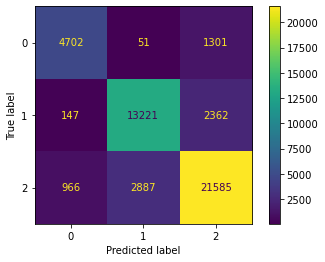

In [25]:
train_and_evaluate_model(model)

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      1514
           1       0.76      0.77      0.76      3933
           2       0.79      0.79      0.79      6359

    accuracy                           0.77     11806
   macro avg       0.74      0.74      0.74     11806
weighted avg       0.77      0.77      0.77     11806



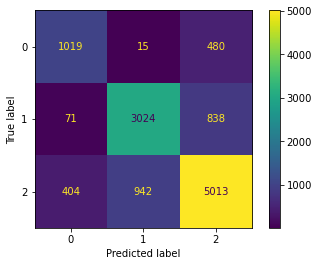

In [26]:
test_and_evaluate_model(model)